In [1]:
import pandas as pd
df= pd.read_csv("clean_df.csv")
df.head()

,id,content
0,etfi0m,americas new drinking problem trump administra...
1,etouq6,trumps gutting environmental rules pushing dar...
2,etp02h,greta thunberg brushes mockery finance chief c...
3,etpv53,crisis change guardian language changes climat...
4,etsaxl,future worse thought


In [2]:
import pandas as pd
import numpy as np

import string
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import re

In [3]:
pd.options.display.max_colwidth = 200


In [4]:
stop_words = stopwords.words('english')

#add punctuation char's to stopwords list
stop_words += list(string.punctuation)
stop_words += ['anxiety','feel', 'give', 'giving', 'help', 'said', 'also', 'rt', 'gave', 'like', 'going', 'even']

In [5]:
def remove_urls(text):
    return re.sub(r'http\S+','', str(text))

In [6]:
df['content'] = df['content'].apply(remove_urls)

In [7]:
lemmatizer = WordNetLemmatizer()

def preprocess(df_text):
    tokens = word_tokenize(df_text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words and len(token) > 3]
    
    lemmatized =[]
    
    for w in stopwords_removed:
        lemmatized.append(lemmatizer.lemmatize(w))
        
    processed = list(filter(lambda x: x.isalpha(), lemmatized))  
        
    return processed

In [8]:
df['lem'] = df['content'].apply(preprocess)

In [9]:
df.head()

,id,content,lem
0,etfi0m,americas new drinking problem trump administration rolls clean water act nnnnpresident trumps epa restricted bodies water federal government regulate territorial seas traditional navigable waters ...,"[america, drinking, problem, trump, administration, roll, clean, water, nnnnpresident, trump, restricted, body, water, federal, government, regulate, territorial, sea, traditional, navigable, wate..."
1,etouq6,trumps gutting environmental rules pushing dark days ignorance eco planet news,"[trump, gutting, environmental, rule, pushing, dark, day, ignorance, planet, news]"
2,etp02h,greta thunberg brushes mockery finance chief cbc news eco planet news,"[greta, thunberg, brush, mockery, finance, chief, news, planet, news]"
3,etpv53,crisis change guardian language changes climate matters environment,"[crisis, change, guardian, language, change, climate, matter, environment]"
4,etsaxl,future worse thought,"[future, worse, thought]"


In [10]:
[len(tokens) for tokens in df['lem'][1]]

[5, 7, 13, 4, 7, 4, 3, 9, 6, 4]

In [11]:
all_words = [word for tokens in df['lem'] for word in tokens]
reddit_lengths = [len(tokens) for tokens in df['lem']]
vocab = sorted(list(set(all_words)))

print('{} tokens total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max subreddit length is {}'.format(max(reddit_lengths)))

236115 tokens total, with a vocabulary size of 26158
Max subreddit length is 1714


In [12]:
word_length = []
for word in all_words:
    word_length.append(len(word))

In [13]:
print('average word size is {}'.format( sum(word_length) / len(word_length)))

average word size is 7.042923998898842


# Exploring the Processed Text


C:\Users\Naim Cavin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


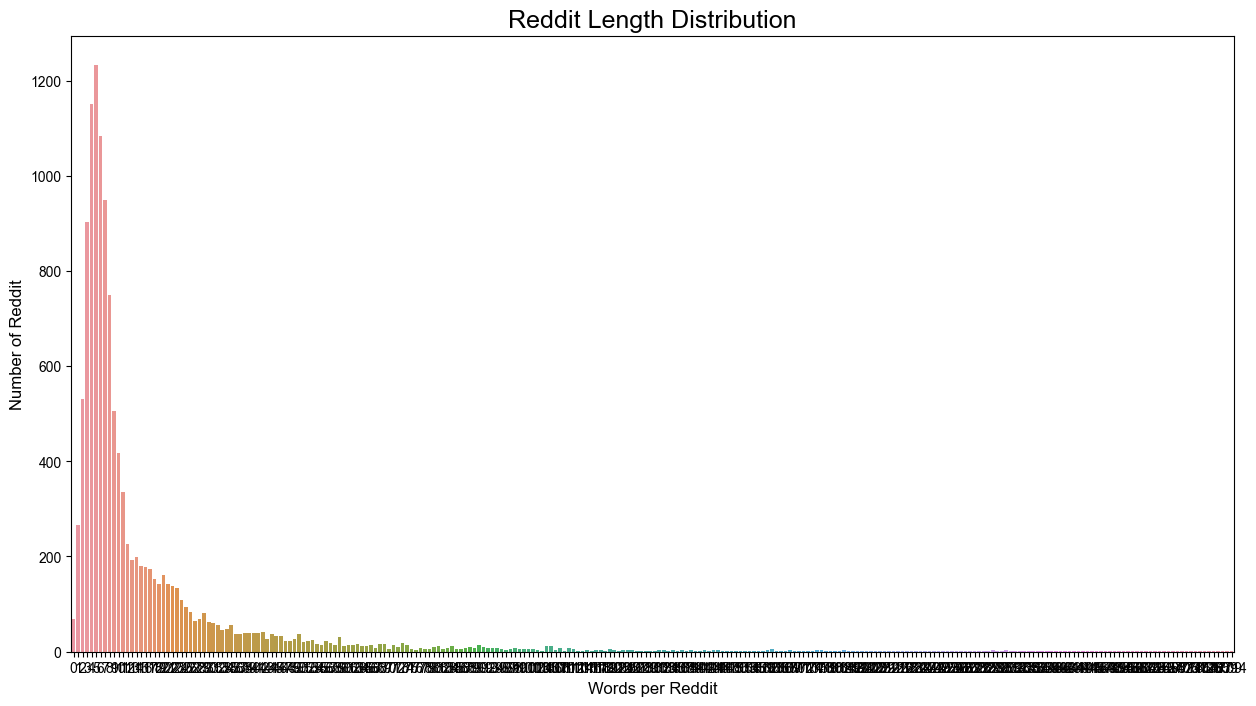

In [14]:
plt.figure(figsize = (15,8))
sns.countplot(reddit_lengths)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.title('Reddit Length Distribution', fontsize = 18)
plt.xlabel('Words per Reddit', fontsize = 12)
plt.ylabel('Number of Reddit', fontsize = 12)
plt.show()


- Distribution of tweet lengths is right-skewed.
- High concentration of tweets containing only 2-20 tokens
- Additional filtering should be done to remove tweets having less than 3 tokens, as I dont believe they will add much value to the model

In [20]:
df1=df.copy()

In [21]:
less_than_3_tokens = df1[df1["lem"].apply(lambda x: len(x)<3)].index

In [22]:
more_than_100_tokens = df1[df1["lem"].apply(lambda x: len(x)>100)].index

In [23]:
df.drop(less_than_3_tokens, inplace = True)


In [25]:
df.drop(more_than_100_tokens, inplace = True)

In [26]:
all_words = [word for tokens in df['lem'] for word in tokens]
reddit_lengths = [len(tokens) for tokens in df['lem']]
vocab = sorted(list(set(all_words)))

print('{} tokens total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max subreddit length is {}'.format(max(reddit_lengths)))

164392 tokens total, with a vocabulary size of 19274
Max subreddit length is 100


C:\Users\Naim Cavin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


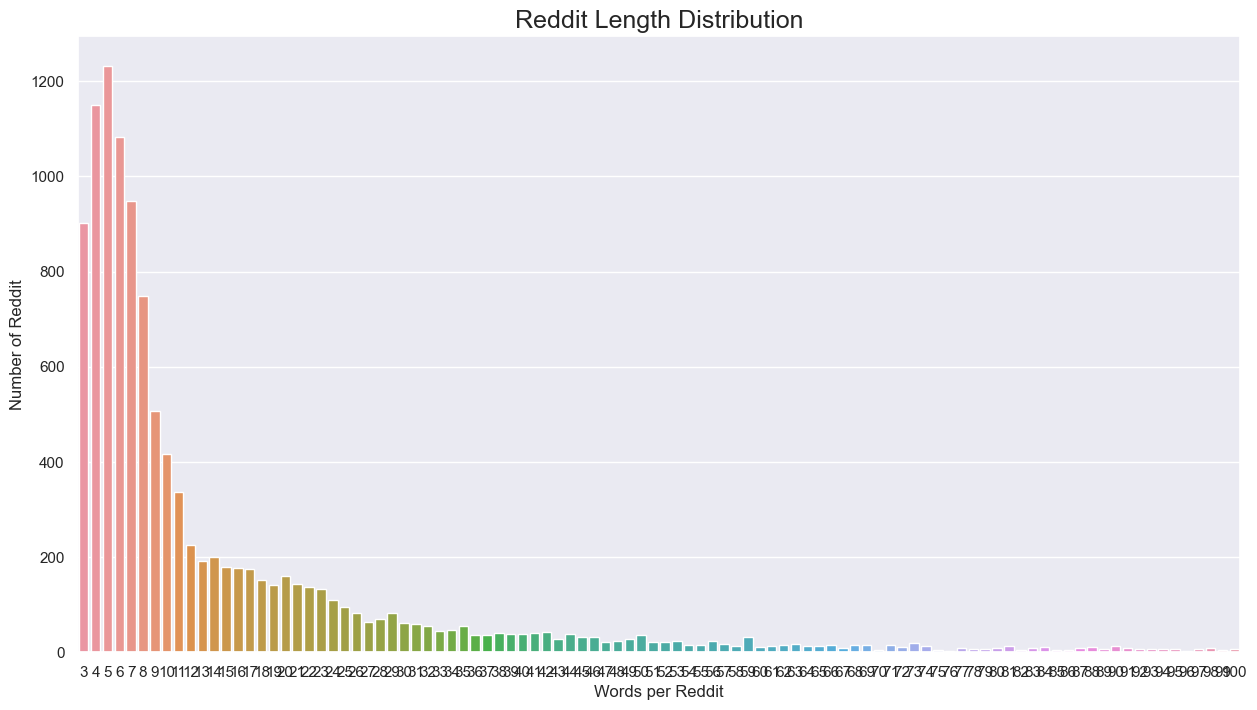

In [27]:
plt.figure(figsize = (15,8))
sns.countplot(reddit_lengths)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.title('Reddit Length Distribution', fontsize = 18)
plt.xlabel('Words per Reddit', fontsize = 12)
plt.ylabel('Number of Reddit', fontsize = 12)
plt.show()

In [28]:
flat_words = [item for sublist in df1['lem'] for item in sublist]

In [29]:
word_freq = FreqDist(flat_words)

In [31]:
word_freq.most_common(50)


[('sustainable', 2628),
 ('sustainability', 2160),
 ('climate', 1551),
 ('change', 1280),
 ('people', 1278),
 ('plastic', 1197),
 ('removed', 1164),
 ('energy', 1082),
 ('green', 1052),
 ('know', 1015),
 ('world', 1005),
 ('company', 949),
 ('year', 933),
 ('food', 927),
 ('need', 903),
 ('carbon', 873),
 ('product', 861),
 ('want', 828),
 ('time', 807),
 ('waste', 790),
 ('project', 767),
 ('water', 754),
 ('good', 752),
 ('environmental', 695),
 ('think', 693),
 ('thing', 677),
 ('looking', 642),
 ('idea', 636),
 ('impact', 615),
 ('work', 564),
 ('find', 564),
 ('life', 552),
 ('environment', 539),
 ('plant', 502),
 ('solar', 494),
 ('industry', 480),
 ('business', 480),
 ('power', 479),
 ('emission', 475),
 ('brand', 473),
 ('better', 470),
 ('community', 464),
 ('survey', 464),
 ('future', 453),
 ('free', 450),
 ('thought', 444),
 ('planet', 438),
 ('system', 438),
 ('global', 434),
 ('solution', 410)]

In [32]:
#retrieve word and count from FreqDist tuples

most_common_count = [x[1] for x in word_freq.most_common(50)]
most_common_word = [x[0] for x in word_freq.most_common(50)]

In [33]:
#create dictionary mapping of word count
top_50_dictionary = dict(zip(most_common_word, most_common_count))

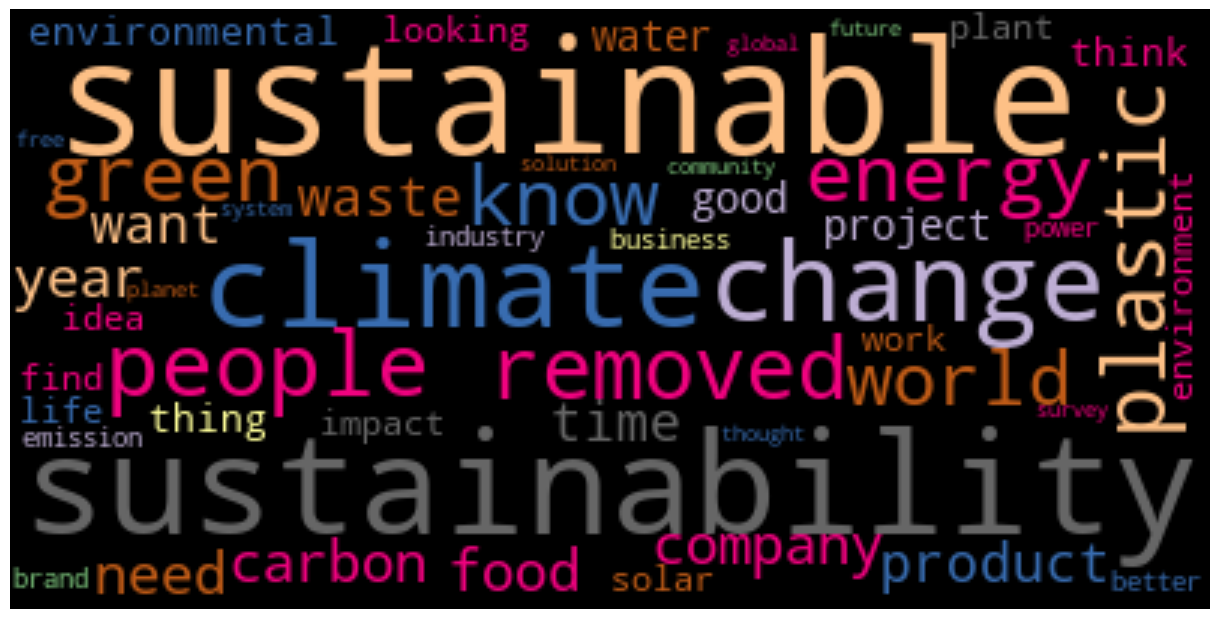

In [34]:
#Create Word Cloud of top 50 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_50_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_50_cloud.png')


plt.show()

# Modeling

In [35]:
text_dict = Dictionary(df1.lem)

In [36]:
text_dict.filter_extremes(no_below = 5, no_above = .90)

In [37]:
txt_out = text_dict.token2id

In [39]:
#for k, v in txt_out.items():
#    print(k,v)

administration 0
america 1
body 2
certain 3
clean 4
drinking 5
federal 6
flow 7
government 8
groundwater 9
here 10
including 11
lake 12
large 13
law 14
longer 15
mean 16
pond 17
portion 18
problem 19
regulate 20
restricted 21
roll 22
sea 23
seasonal 24
stream 25
traditional 26
trump 27
unfortunately 28
water 29
wetland 30
year 31
dark 32
day 33
environmental 34
news 35
planet 36
pushing 37
rule 38
brush 39
chief 40
finance 41
greta 42
thunberg 43
change 44
climate 45
crisis 46
environment 47
guardian 48
language 49
matter 50
future 51
thought 52
worse 53
bury 54
head 55
snow 56
amazing 57
bamboo 58
benefit 59
combat 60
plant 61
super 62
action 63
community 64
effective 65
engaging 66
lesson 67
awareness 68
billion 69
carbon 70
commitment 71
concern 72
corporate 73
eliminate 74
emission 75
greater 76
invest 77
microsoft 78
pledged 79
race 80
raise 81
raising 82
stake 83
wider 84
good 85
hand 86
people 87
project 88
battery 89
charging 90
electric 91
myth 92
vehicle 93
green 94
idea 95
d

australian 1618
completing 1619
degree 1620
draw 1621
educational 1622
enrolled 1623
enter 1624
investigating 1625
master 1626
nnif 1627
nthis 1628
outlining 1629
participant 1630
participating 1631
prioritise 1632
second 1633
seeking 1634
wellbeing 1635
cultural 1636
conversion 1637
layer 1638
nrel 1639
percent 1640
rate 1641
record 1642
reduces 1643
wood 1644
fiction 1645
separating 1646
leave 1647
missing 1648
newsletter 1649
primary 1650
realistically 1651
register 1652
registered 1653
switch 1654
thrown 1655
vote 1656
bail 1657
caused 1658
chain 1659
forced 1660
lost 1661
shutdown 1662
contaminated 1663
discus 1664
focal 1665
allowed 1666
landscape 1667
modern 1668
political 1669
advise 1670
international 1671
organization 1672
endless 1673
peril 1674
detail 1675
driesenaar 1676
experience 1677
method 1678
region 1679
systemic 1680
urgent 1681
village 1682
writer 1683
cheese 1684
driving 1685
similar 1686
progression 1687
harvesting 1688
rice 1689
domestic 1690
gross 1691
metric 1

eye 3117
stable 3118
sequestration 3119
dinner 3120
nnthis 3121
section 3122
sunday 3123
delivered 3124
cocacola 3125
queen 3126
lawn 3127
status 3128
symbol 3129
visible 3130
copyright 3131
avocado 3132
ridiculous 3133
throwing 3134
lawsuit 3135
ordered 3136
respond 3137
drilling 3138
plane 3139
explosion 3140
monitor 3141
antonio 3142
pact 3143
advocating 3144
pocket 3145
arm 3146
soar 3147
airline 3148
optimism 3149
glass 3150
pile 3151
repurposing 3152
louis 3153
collecting 3154
december 3155
door 3156
visual 3157
africa 3158
coin 3159
currency 3160
emitted 3161
restoration 3162
nnhi 3163
offsetting 3164
stage 3165
steak 3166
killed 3167
patagonia 3168
drone 3169
applies 3170
themnni 3171
pension 3172
vietnam 3173
frankfurt 3174
gesucht 3175
hiring 3176
divest 3177
retirement 3178
wrapping 3179
alert 3180
dolphin 3181
bailout 3182
maryland 3183
accord 3184
anniversary 3185
highlight 3186
considers 3187
ambition 3188
shown 3189
knife 3190
behaviour 3191
keen 3192
rush 3193
stopping 

ladakh 4867
officer 4868
targeted 4869
tear 4870
unnecessarily 4871
vent 4872
violent 4873
watern 4874
wool 4875
fixed 4876
consultancy 4877
arrive 4878
headline 4879
introduces 4880
donates 4881
refused 4882
comfortably 4883
anyways 4884
methodology 4885
prevents 4886
bound 4887
norwegian 4888
spirit 4889
aluminium 4890
fertiliser 4891
optimistic 4892
earthling 4893
nand 4894
sheer 4895
immense 4896
pod 4897
rough 4898
undoubtedly 4899
organism 4900
infinitely 4901
usda 4902
sequester 4903
pantry 4904
highspeed 4905
etsy 4906
shampooconditioner 4907
switched 4908
notion 4909
demonstrates 4910
alien 4911
busy 4912
civilization 4913
realise 4914
rack 4915
comfortable 4916
lunch 4917
refillable 4918
minimize 4919
spice 4920
barely 4921
handwash 4922
composter 4923
maximum 4924
fiber 4925
fee 4926
transaction 4927
passive 4928
rag 4929
accountability 4930
trustworthy 4931
awful 4932
shipment 4933
cola 4934
coop 4935
requesting 4936
soapbox 4937
fit 4938
deodorant 4939
rarely 4940
equally 

In [38]:
#text_dict.save_as_text('tweet_text_dict.txt')

In [40]:
reddits_bow = [text_dict.doc2bow(reddit) for reddit in df1['lem']]

In [43]:
reddits_bow[0]

[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 2),
 (8, 2),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 2),
 (26, 1),
 (27, 2),
 (28, 1),
 (29, 7),
 (30, 2),
 (31, 1)]

In [46]:
print(len(df1['lem'][0]))
df1['lem'][0]

59


['america',
 'drinking',
 'problem',
 'trump',
 'administration',
 'roll',
 'clean',
 'water',
 'nnnnpresident',
 'trump',
 'restricted',
 'body',
 'water',
 'federal',
 'government',
 'regulate',
 'territorial',
 'sea',
 'traditional',
 'navigable',
 'water',
 'perennial',
 'intermittent',
 'tributary',
 'water',
 'certain',
 'lake',
 'pond',
 'impoundment',
 'wetland',
 'adjacent',
 'jurisdictional',
 'water',
 'unfortunately',
 'mean',
 'federal',
 'government',
 'longer',
 'enforcing',
 'law',
 'water',
 'including',
 'groundwater',
 'wetland',
 'adjacent',
 'large',
 'body',
 'water',
 'seasonal',
 'stream',
 'flow',
 'portion',
 'year',
 'ephemeral',
 'stream',
 'flow',
 'rainstorm',
 'here',
 'mean']

In [47]:
k = 5
reddits_lda = LdaModel(reddits_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)

In [48]:
reddits_lda.show_topics()

[(0,
  '0.026*"removed" + 0.015*"home" + 0.009*"solar" + 0.009*"energy" + 0.008*"sustainable" + 0.008*"building" + 0.007*"city" + 0.006*"house" + 0.006*"climate" + 0.006*"green"'),
 (1,
  '0.031*"climate" + 0.022*"change" + 0.022*"carbon" + 0.017*"energy" + 0.012*"emission" + 0.010*"power" + 0.010*"world" + 0.009*"nuclear" + 0.009*"global" + 0.008*"year"'),
 (2,
  '0.033*"plastic" + 0.022*"sustainable" + 0.014*"waste" + 0.013*"water" + 0.012*"brand" + 0.011*"fashion" + 0.010*"product" + 0.009*"packaging" + 0.009*"material" + 0.009*"food"'),
 (3,
  '0.030*"sustainability" + 0.021*"sustainable" + 0.012*"removed" + 0.012*"know" + 0.009*"product" + 0.009*"want" + 0.009*"looking" + 0.008*"people" + 0.008*"idea" + 0.008*"survey"'),
 (4,
  '0.014*"people" + 0.014*"sustainable" + 0.010*"sustainability" + 0.009*"green" + 0.009*"impact" + 0.009*"tree" + 0.008*"world" + 0.008*"community" + 0.007*"future" + 0.006*"meat"')]

### From Eyeballing

- There does not seem to be a clear distinction between topics.

In [49]:
def format_topics_sentences(ldamodel=None, corpus=reddits_bow, texts=df1['lem']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[reddits_bow]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=reddits_lda, corpus=reddits_bow, texts=df1['lem'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.4839,"plastic, sustainable, waste, water, brand, fashion, product, packaging, material, food","[america, drinking, problem, trump, administration, roll, clean, water, nnnnpresident, trump, restricted, body, water, federal, government, regulate, territorial, sea, traditional, navigable, wate..."
1,1,0.0,0.9095,"removed, home, solar, energy, sustainable, building, city, house, climate, green","[trump, gutting, environmental, rule, pushing, dark, day, ignorance, planet, news]"
2,2,0.0,0.5070,"removed, home, solar, energy, sustainable, building, city, house, climate, green","[greta, thunberg, brush, mockery, finance, chief, news, planet, news]"
3,3,1.0,0.7911,"climate, change, carbon, energy, emission, power, world, nuclear, global, year","[crisis, change, guardian, language, change, climate, matter, environment]"
4,4,4.0,0.5461,"people, sustainable, sustainability, green, impact, tree, world, community, future, meat","[future, worse, thought]"
5,5,2.0,0.5505,"plastic, sustainable, waste, water, brand, fashion, product, packaging, material, food","[tooyou, bury, head, snow]"
6,6,1.0,0.5546,"climate, change, carbon, energy, emission, power, world, nuclear, global, year","[bamboo, super, plant, combat, climate, change, amazing, benefit]"
7,7,4.0,0.5097,"people, sustainable, sustainability, green, impact, tree, world, community, future, meat","[climate, action, effective, lesson, engaging, community]"
8,8,0.0,0.5287,"removed, home, solar, energy, sustainable, building, city, house, climate, green","[microsoft, raise, corporate, climate, commitment, pledged, eliminate, carbon, emission, invest, billion, wider, climate, commitment, raising, stake, corporate, race, greater, awareness, environme..."
9,9,3.0,0.8375,"sustainability, sustainable, removed, know, product, want, looking, people, idea, survey","[project, hand, people, good]"


In [55]:
def plot_top_words(lda=reddits_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=.5, hspace=.5)
    plt.figure(figsize=(30,20))
    plt.show()
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
#plot_top_words()

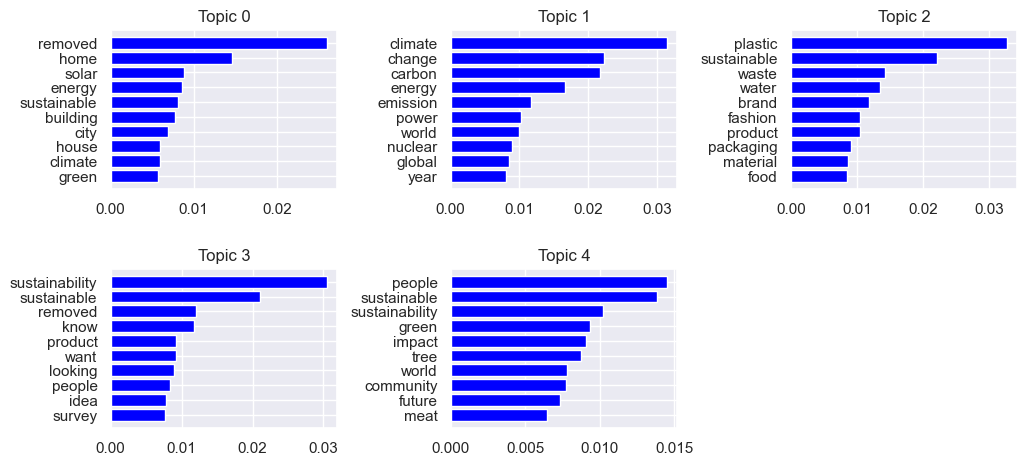

<Figure size 3000x2000 with 0 Axes>

In [57]:
plot_top_words()

### Next Steps
- Using n-grams to connect words that occur together commonly, such as “mental”, and “health”. A bi-gram would retain “mental_health” so that the model reads it as one token.
- Additional filtering of commonly occurring words that aren’t providing any meaningful context.
- Calculating a Coherence Score, and find optimal parameters for k topics, number of passes, etc.
- Collect and experiment with a more diverse,larger dataset.